In [106]:
import os
import numpy as np
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

mpl.rcParams['figure.figsize'] = (5,3)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

- 데이터셋이 작은 경우, cnn을 통한 모형 학습이 어려워 정확도가 낮을 수 있음
- (해결) data augmentation(이미지 증식)을 통해 데이터의 수를 늘림

- data augmentation이란?
 - 원본 이미지에 다양한 변형을 가해서 학습 데이터 이미지를 늘리는 것과 유사한 효과를 가져옴
 - 원본 이미지를 단순히 늘리는 것이 아닌 색이나 각도의 변형을 통해 늘림
 - cnn의 성능을 높이고 overfitting을 극복할 수 있는 방법


In [231]:
def make_prediction(model=None,img_vector=[],
                    label_dict={},top_N=3, 
                    model_input_shape=None):
    if model:
        # get model input shape
        if not model_input_shape:
            model_input_shape = (1,) + dataset[random_batch_indx[img_idx]].shape
            
        # get prediction
        prediction = model.predict(img_vector.reshape(model_input_shape))[0]
        
        
        # get top N with confidence
        labels_predicted = [label_dict[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
        confidence_predicted = np.sort(prediction)[::-1][:top_N]
        
        return labels_predicted, confidence_predicted

In [232]:

def plot_predictions(model,dataset,
                    dataset_labels,label_dict,
                    batch_size,grid_height,grid_width):
    if model:
        f, ax = plt.subplots(grid_width, grid_height)
        f.set_size_inches(12, 12)
        
        random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

        img_idx = 0
        for i in range(0, grid_width):
            for j in range(0, grid_height):
                actual_label = label_dict.get(dataset_labels[random_batch_indx[img_idx]].argmax())
                preds,confs_ = make_prediction(model,
                                              img_vector=dataset[random_batch_indx[img_idx]],
                                              label_dict=label_dict,
                                              top_N=1)
                ax[i][j].axis('off')
                ax[i][j].set_title('Actual:'+actual_label[:10]+\
                                    '\nPredicted:'+preds[0] + \
                                    '(' +str(round(confs_[0],2)) + ')')
                ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
                img_idx += 1

        plt.subplots_adjust(left=0, bottom=0, right=1, 
                            top=1, wspace=0.4, hspace=0.55)    
 

In [84]:
# # .DS_Store파일 로드가 되어 오류가 남 --> 해당 파일은 Desktop Services Store 약자로, macOS 운영체제에서 Finder로 폴더를 볼 때마다 자동으로 생성되는 파일
# # 해당 파일을 삭제하는 방법 : 터미널에서 디렉토리 이동한 후 ls -a | grep .DS_Store 명령어로 해당 파일이 있는지 확인 --> rm .DS_Store 로 삭제하기

# import PIL
# from PIL import Image
# import io

# dirr = 'train_dataset/Bathroom/'
# path = os.listdir('train_dataset/Bathroom/')
# for p in path:
#     try:
#         with open(dirr + p, 'rb') as f:
#             data = f.read()
#         print(p)
#         data_io = io.BytesIO(data)
#         img = Image.open(data_io)
#     except :
#         break

In [93]:
# 이외에도 UnidentifiedImageError: cannot identify image file <_io.BytesIO object at  오류가 여전히 존재

# import os
# from PIL import Image

# folder_path = "train_dataset/"
# extensions = []
# corupt_img_paths=[]
# for fldr in os.listdir(folder_path):
#     sub_folder_path = os.path.join(folder_path, fldr)
#     for filee in os.listdir(sub_folder_path):
#         file_path = os.path.join(sub_folder_path, filee)
#         print('** Path: {}  **'.format(file_path), end="\r", flush=True)
#         try:
#             im = Image.open(file_path)
#         except:
#             print(file_path)
#             os.remove(file_path)
#             continue
#         else:
#             rgb_im = im.convert('RGB')
#             if filee.split('.')[1] not in extensions:
#                 extensions.append(filee.split('.')[1])

train_dataset/Bathroom/Bathroom_97.jpgom_97.jpg  ****


/Users/choinjeong/anaconda3/envs/cho_3_9/lib/python3.9/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  for i in range(0, len(transparency))


In [24]:
# 이미지 데이터 생성기 설정

data_dir = 'train_dataset/'
test_dir = 'test_dataset/'

image_size = (224,224) # 이미지 크기 (128,128)
batch_size = 32       # 배치 크기

train_gen = ImageDataGenerator(rescale = 1/255,         # 픽셀값을 0~1 사이로 스케일링
                             validation_split=0.2,      # 검증 데이터 비율
                             rotation_range = 40,       # random rotation 각도 범위(0~180)
                             width_shift_range = 0.2,   # 수평 이동 범위(비율) [-0.2, 0, +0.2] ex)[-1, -0.5, 0, 0.5, 1]
                             height_shift_range = 0.2,  # 수직 이동 범위(비율)
                             shear_range = 0.2,         # 기울어지는 변환의 각도 범위(반시계 방향)
                             zoom_range = 0.2,          # 확대 비율([lower, upper] = [1-zoom_range, 1+zoom_range])
                             horizontal_flip = True     # 수평으로 뒤집음
                            )

valid_gen = ImageDataGenerator(rescale = 1/255) # rescale만 진행

In [25]:

train_generator = train_gen.flow_from_directory(data_dir,
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              class_mode='categorical') # 학습데이터로 사용, categorical

validation_generator = valid_gen.flow_from_directory(test_dir,
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              class_mode='categorical') # 검증데이터로 사용

Found 9373 images belonging to 5 classes.
Found 2349 images belonging to 5 classes.


In [26]:
train_generator.class_indices

{'Bathroom': 0, 'Bedroom': 1, 'Dinning': 2, 'Kitchen': 3, 'Livingroom': 4}

In [27]:
# numpy 배열로 전환
train_images = []
train_labels = []

for images, labels in train_generator:
    train_images.extend(images)
    train_labels.extend(labels)
    if len(train_images) >= len(train_generator.filepaths):
        break

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# 클래스 라벨을 숫자로 변환
train_labels_numeric = np.argmax(train_labels, axis=1) # axis=1, 클래스가 2개인 경우 axis안함

# 변환된 데이터 확인
print("train images shape:", train_images.shape)
print("train labels shape:", train_labels_numeric.shape)

/Users/choinjeong/anaconda3/envs/cho_3_9/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train images shape: (9373, 224, 224, 3)
train labels shape: (9373,)


In [60]:
np.unique(test_labels_numeric, return_counts=True)

(array([0, 1, 2, 3, 4]), array([443, 636, 366, 399, 505]))

In [28]:
# numpy 배열로 전환
test_images = []
test_labels = []

for images, labels in validation_generator:
    test_images.extend(images)
    test_labels.extend(labels)
    if len(test_images) >= len(validation_generator.filepaths):
        break

test_images = np.array(test_images)
valid_labels = np.array(test_labels)

# 클래스 라벨을 숫자로 변환
test_labels_numeric = np.argmax(test_labels, axis=1) # axis=1

# 변환된 데이터 확인
print("train images shape:", test_images.shape)
print("train labels shape:", test_labels_numeric.shape)

train images shape: (2349, 224, 224, 3)
train labels shape: (2349,)


In [127]:
import random
random.randint(0,3)

2

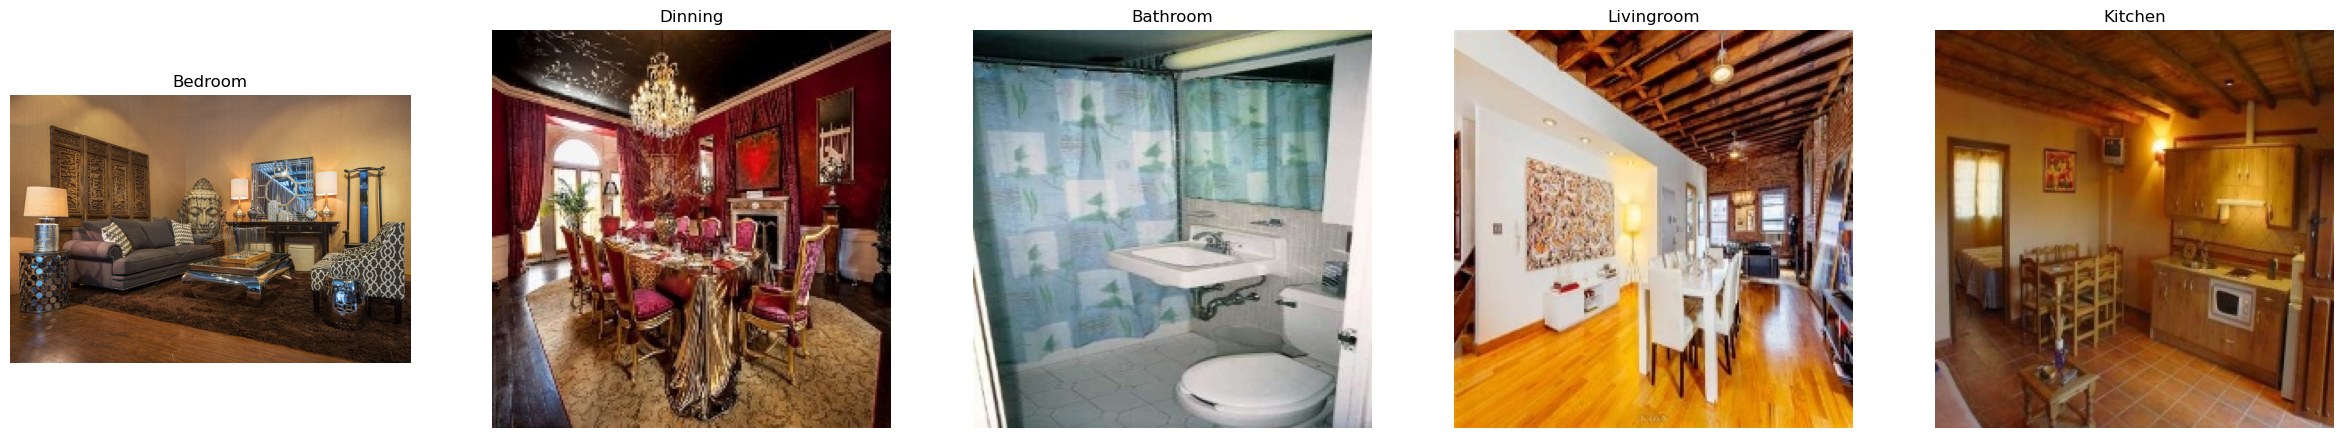

In [132]:
classes = os.listdir('train_dataset')

plt.figure(figsize=(30 , 30))
for i in range(len(classes)):
    images = os.listdir('train_dataset'+'/'+classes[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread('train_dataset'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

In [30]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape = (224,224,3),
                                                      include_top=False,
                                                      weights='imagenet')

17225924/17225924 [==============================] - 2s 0us/step


In [75]:
metrics = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='prc', curve='PR'), #precision-recall curve
]

In [79]:
model = models.Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(5, activation="softmax", name='classification'))

In [80]:
# 모델 컴파일
model.compile(optimizer='adam', # adam
              loss = 'categorical_crossentropy', # 다중 클래스 분류 손실, binary, sparse
              metrics=metrics)

In [81]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', # stop 조건으로 관찰할 변수 선택
                                                 patience = 5) # 10 Epoch동안 val_accuracy가 개선되지 않는다면 종료

history = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch = len(train_generator),
                    validation_data = validation_generator,
                    validation_steps = len(validation_generator),
                    callbacks = [earlystopping]
                    )

Epoch 1/100


2023-09-01 10:38:18.448171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


293/293 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.9616 - precision: 0.9218 - recall: 0.8830 - prc: 0.9600

2023-09-01 10:41:26.526774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


293/293 [==============================] - 203s 688ms/step - loss: 0.3122 - accuracy: 0.9616 - precision: 0.9218 - recall: 0.8830 - prc: 0.9600 - val_loss: 0.5490 - val_accuracy: 0.9366 - val_precision: 0.8574 - val_recall: 0.8191 - val_prc: 0.9100
Epoch 2/100
293/293 [==============================] - 201s 685ms/step - loss: 0.2821 - accuracy: 0.9626 - precision: 0.9220 - recall: 0.8881 - prc: 0.9634 - val_loss: 0.4633 - val_accuracy: 0.9458 - val_precision: 0.8778 - val_recall: 0.8467 - val_prc: 0.9307
Epoch 3/100
293/293 [==============================] - 200s 683ms/step - loss: 0.2510 - accuracy: 0.9664 - precision: 0.9302 - recall: 0.8997 - prc: 0.9708 - val_loss: 0.5690 - val_accuracy: 0.9385 - val_precision: 0.8576 - val_recall: 0.8306 - val_prc: 0.9041
Epoch 4/100
293/293 [==============================] - 203s 694ms/step - loss: 0.2432 - accuracy: 0.9672 - precision: 0.9301 - recall: 0.9041 - prc: 0.9718 - val_loss: 0.5084 - val_accuracy: 0.9464 - val_precision: 0.8726 - val_r

In [83]:
model.save('mobilenet_basic2.h5')

In [97]:
model.evaluate(validation_generator)

2023-09-01 13:31:38.785611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


74/74 [==============================] - 14s 186ms/step - loss: 0.4483 - accuracy: 0.9483 - precision: 0.8810 - recall: 0.8574 - prc: 0.9358


[0.448337584733963,
 0.9483184218406677,
 0.881014883518219,
 0.8573861122131348,
 0.9357882142066956]

In [102]:
valid_metrics = model.evaluate(validation_generator)

print('loss         : ', valid_metrics[0])
print('accuracy     : ', valid_metrics[1])
print('precision    : ', valid_metrics[2])
print('recall       : ', valid_metrics[3])
print('prc          : ', valid_metrics[4])

loss         :  0.4483376443386078
accuracy     :  0.9483184218406677
precision    :  0.881014883518219
recall       :  0.8573861122131348
prc          :  0.9357882142066956


In [142]:
model.summary()
# Layer (type)
# - Conv2D : 2D 이미지에서 특징을 추출하기 위해 사용되는 레이어. 작은 윈도우(커널)를 이미지 위를 슬라이딩 하면서 특징을 감지
# - MaxPooling2D : 이미지 데이터의 공간 크기를 줄이기 위해 사용
# output shape - (None, 126, 126, 32) : 첫 번째 차원은 배치 크기, 나머지 차원은 데이터의 형태
# param #  : 각 레이어의 학습 가능한 매개변수의 수. 이 수치는 모델이 학습 중에 업데이트 되는 가중치의 수를 의미

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 50176)            

In [133]:
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [109]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

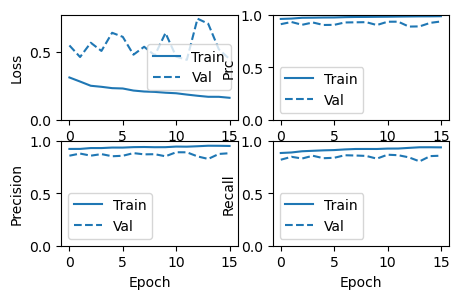

In [110]:
plot_metrics(history)

In [111]:
predictions = model.predict(test_images)
print('validation_labels : ', np.argmax(test_labels[:10],axis=1))
print('prediction_labels : ', np.argmax(predictions[:10],axis=1))

74/74 [==============================] - 10s 134ms/step
validation_labels :  [0 1 4 3 0 3 3 1 2 0]
prediction_labels :  [0 1 4 3 0 3 3 1 2 0]


1/1 [==============================] - 0s 23ms/step


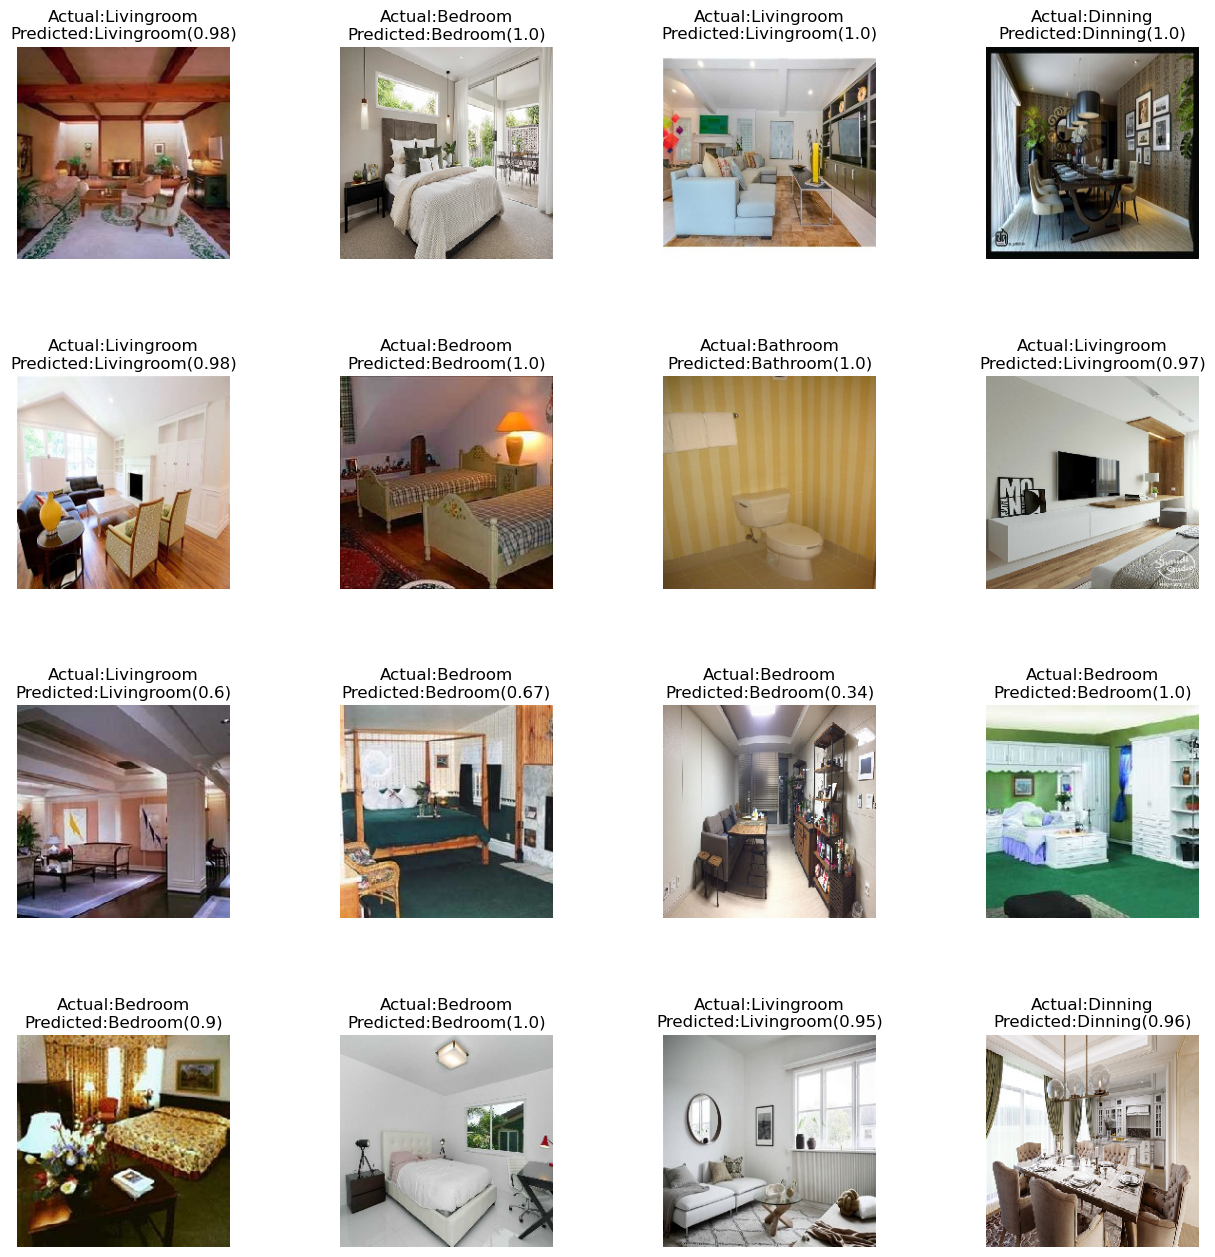

In [263]:
label_dict = train_generator.class_indices
label_dict = {v: k for k, v in label_dict.items()}

plot_predictions(model=model,dataset=test_images,
                       dataset_labels=test_labels,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)

In [57]:
# 새로운 이미지 분류 예측
import cv2
# new_image = plt.imread('valid/bathroom.jpeg') # 0
# new_image = plt.imread('valid/bedroom.jpeg') # 1
# new_image = plt.imread('valid/dinning.jpeg') # 2
# new_image = plt.imread('valid/kitchen.jpeg') # 3
new_image = plt.imread('valid/livingroom.jpeg') # 4

# plt.imshow(new_image)
# plt.show()
# new_image = cv2.resize(new_image,(128,128))
# new_image = new_image.reshape(1,128,128,3)
new_image = cv2.resize(new_image, (224,224))
new_image = np.reshape(new_image, [1, 224, 224, 3])
print(np.argmax(model.predict(new_image)))

# prediction = model.predict(new_image)
# predicted_class = np.argmax(prediction)
# print('예측 클래스:', predicted_class)


1/1 [==============================] - 0s 30ms/step
1


In [24]:
train_generator.class_indices

{'Bathroom': 0, 'Bedroom': 1, 'Dinning': 2, 'Kitchen': 3, 'Livingroom': 4}